# Sentinel data

![](https://www.defensa.com/foto-articulo-fichero_22889_20200623.jpg,800,700,0.jpg)

In [2]:
import sys
import os

In [6]:
import folium
import geopandas as gpd
import pandas as pd

In [7]:
import matplotlib.pyplot as plt

In [8]:
import rasterio 
from rasterio import plot
from rasterio.plot import show
from rasterio.mask import mask

In [9]:
from osgeo import gdal

In [7]:
from sentinelsat.sentinel import SentinelAPI

## Guanacaste

In [26]:
name = 'guanacaste'

## Use previously saved file

In [1]:
res = {'path':'./datos/downloads/guanacaste/S2A_MSIL1C_20230518T155901_N0509_R097_T16PFS_20230518T212428.zip'}

## Find images

In [2]:
from pathlib import Path

In [3]:
base_path = Path(res['path']).with_suffix('.SAFE')

In [4]:
for l in (base_path / 'GRANULE').iterdir():
    print(l)

datos/downloads/guanacaste/S2A_MSIL1C_20230518T155901_N0509_R097_T16PFS_20230518T212428.SAFE/GRANULE/L1C_T16PFS_A041278_20230518T161926


### Extracting bands

![](https://sentinels.copernicus.eu/image/image_gallery?uuid=c5fa6c3e-2978-4fb8-ac95-3be9c5171be2&groupId=247904&t=1345630320883)

In [10]:
band_names = pd.DataFrame(
    [
('B01','Ultra Blue'),
('B02','Blue'),
('B03','Green'),
('B04','Red'),
('B08','NIR')
], columns=['band','name'])

In [11]:
band_names

,band,name
0,B01,Ultra Blue
1,B02,Blue
2,B03,Green
3,B04,Red
4,B08,NIR


## Ruta de las imágenes en el SAFE

In [15]:
bands = next((Path.cwd() / Path(res['path']).with_suffix('.SAFE') / 'GRANULE').iterdir()) / 'IMG_DATA' 

In [16]:
bands

PosixPath('/home/alabarga/Teaching/geospatial-python-cr23/course/sesion-3-satellite-imaging/datos/downloads/guanacaste/S2A_MSIL1C_20230518T155901_N0509_R097_T16PFS_20230518T212428.SAFE/GRANULE/L1C_T16PFS_A041278_20230518T161926/IMG_DATA')

In [18]:
blue_band = [l for l in bands.iterdir() if '_B02' in l.name][0]
green_band = [l for l in bands.iterdir() if '_B03' in l.name][0]
red_band = [l for l in bands.iterdir() if '_B04' in l.name][0]
nir_band = [l for l in bands.iterdir() if '_B08' in l.name][0]

In [19]:
blue_band

PosixPath('/home/alabarga/Teaching/geospatial-python-cr23/course/sesion-3-satellite-imaging/datos/downloads/guanacaste/S2A_MSIL1C_20230518T155901_N0509_R097_T16PFS_20230518T212428.SAFE/GRANULE/L1C_T16PFS_A041278_20230518T161926/IMG_DATA/T16PFS_20230518T155901_B02.jp2')

## Load bands

In [20]:
blue = rasterio.open(blue_band, driver='JP2OpenJPEG') 
green = rasterio.open(green_band, driver='JP2OpenJPEG') 
red = rasterio.open(red_band, driver='JP2OpenJPEG') 
nir = rasterio.open(nir_band, driver='JP2OpenJPEG')

In [21]:
red

<open DatasetReader name='/home/alabarga/Teaching/geospatial-python-cr23/course/sesion-3-satellite-imaging/datos/downloads/guanacaste/S2A_MSIL1C_20230518T155901_N0509_R097_T16PFS_20230518T212428.SAFE/GRANULE/L1C_T16PFS_A041278_20230518T161926/IMG_DATA/T16PFS_20230518T155901_B04.jp2' mode='r'>

In [22]:
help(red.read)

Help on built-in function read:

read(...) method of rasterio.io.DatasetReader instance
    Read band data and, optionally, mask as an array.
    
    A smaller (or larger) region of the dataset may be specified and
    it may be resampled and/or converted to a different data type.
    
    Parameters
    ----------
    indexes : int or list, optional
        If `indexes` is a list, the result is a 3D array, but is
        a 2D array if it is a band index number.
    out : numpy ndarray, optional
        As with Numpy ufuncs, this is an optional reference to an
        output array into which data will be placed. If the height
        and width of `out` differ from that of the specified
        window (see below), the raster image will be decimated or
        replicated using the specified resampling method (also see
        below). This parameter cannot be combined with `out_shape`.
    
        *Note*: the method's return value may be a view on this
        array. In other words, `ou

In [23]:
red_data = red.read(1)

In [24]:
red_data

array([[1724, 1758, 1812, ..., 1828, 1793, 1761],
       [1757, 1707, 1760, ..., 1816, 1840, 1816],
       [1784, 1776, 1746, ..., 1914, 1864, 1857],
       ...,
       [1619, 1574, 1472, ..., 1293, 1318, 1313],
       [1567, 1592, 1512, ..., 1321, 1308, 1313],
       [1565, 1598, 1569, ..., 1326, 1308, 1331]], dtype=uint16)

## Generate RGB image

In [27]:
with rasterio.open(f'results/{name}.tiff','w',
                   driver='Gtiff', 
                   width=blue.width, 
                   height=blue.height, 
                   count=3, crs=blue.crs,
                   transform=blue.transform, 
                   dtype=blue.dtypes[0]) as rgb:
    rgb.write(blue.read(1),3) 
    rgb.write(green.read(1),2) 
    rgb.write(red.read(1),1) 
    rgb.close()

## Crop to defined boundary

In [38]:
im = rasterio.open(f'results/{name}.tiff')

In [37]:
check_crs = im.crs
check_crs

CRS.from_epsg(32616)

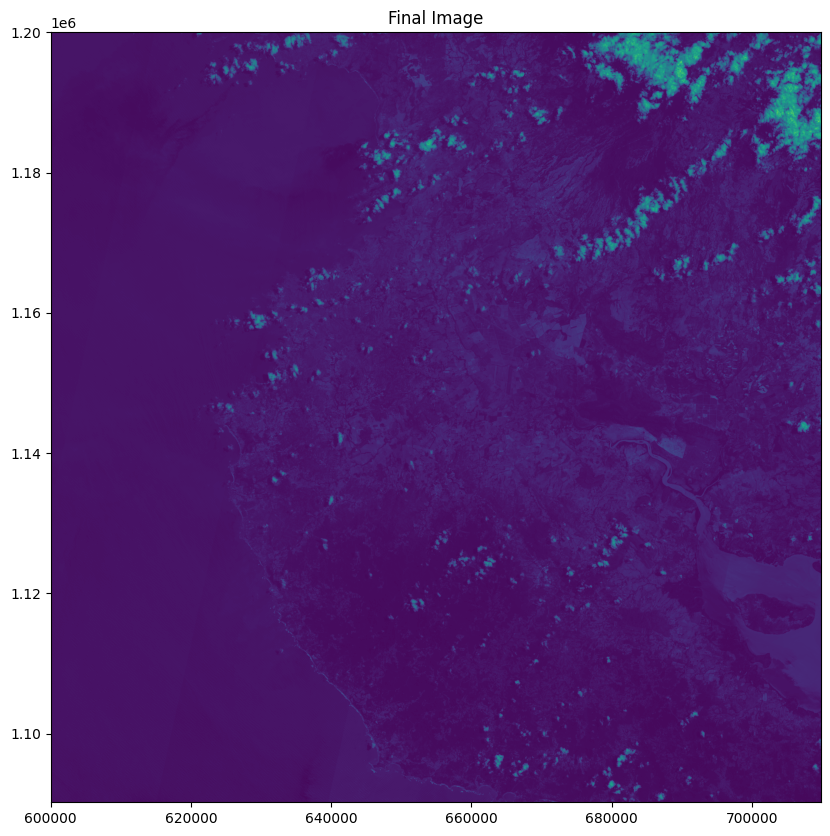

<Axes: title={'center': 'Final Image'}>

In [39]:
plt.figure(figsize=(10,10))
plt.title('Final Image')
plot.show(im, adjust='linear')

- https://github.com/sorabatake/article_9987_SentinelAPI

## Convert to JPG

In [56]:
im.size

(10980, 10980)

In [58]:
options_list = [
    '-ot Byte',
    '-of JPEG',
    '-outsize 1024 1024',
    '-scale 0 250 0 30'
] 
options_string = " ".join(options_list)

gdal.Translate(f'results/{name}.jpg',
               f'results/{name}.tiff',
               options=options_string)



<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fd405552010> >

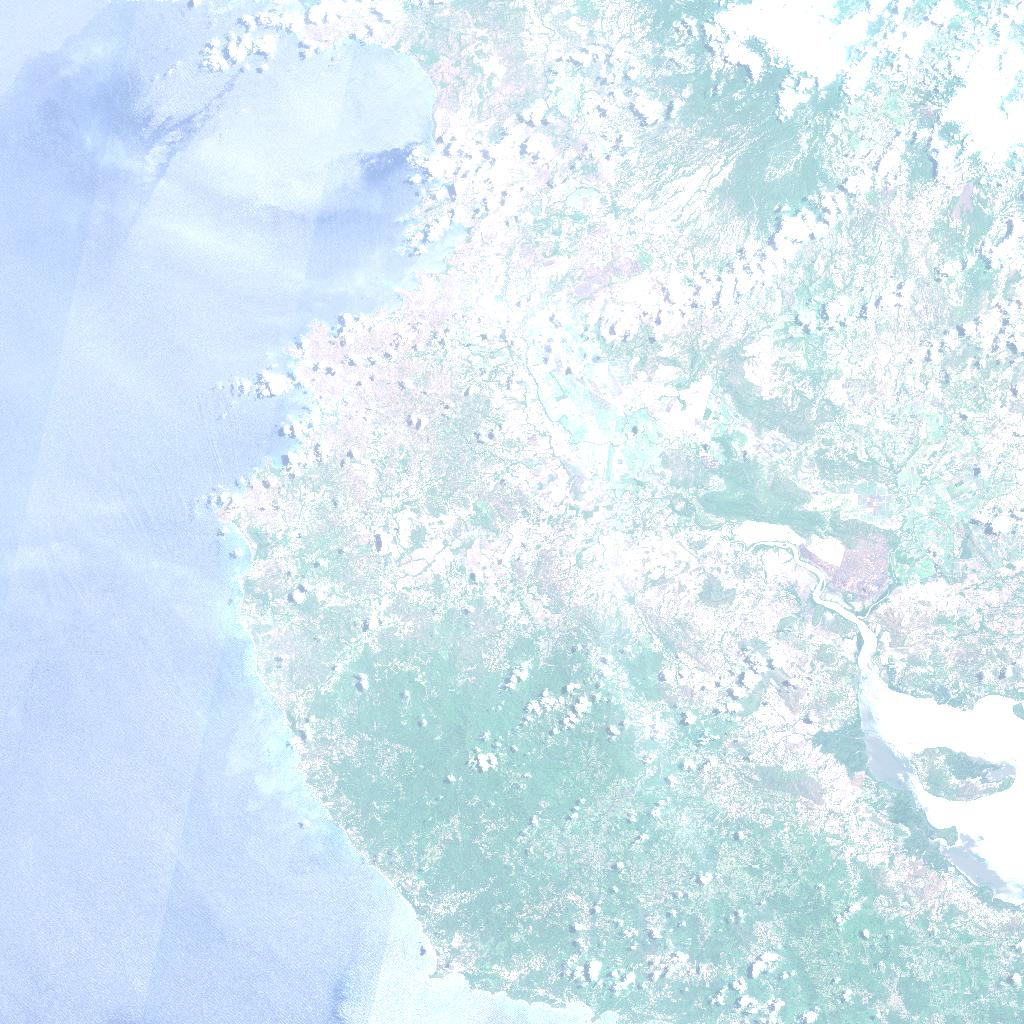

In [59]:
from PIL import Image
im = Image.open(f'results/{name}.jpg')
im



## Convert to xarray

In [64]:
import xarray as xr
import numpy as np

In [65]:
def convert_to_xarray(images, band_names, crs):
    # Concatenate the images along the 'bands' dimension to create a 3D array
    stacked_images = np.stack(images, axis=0)

    # Create a DataArray with the stacked images
    xarr_data = xr.DataArray(stacked_images, dims=('bands', 'y', 'x'))

    # Set coordinate values for x and y dimensions
    xarr_data.coords['x'] = np.arange(0, stacked_images.shape[2])
    xarr_data.coords['y'] = np.arange(0, stacked_images.shape[1])

    # Add a 'bands' coordinate with band names
    xarr_data.coords['bands'] = band_names

    # Set the coordinate reference system (CRS) as an attribute
    xarr_data.attrs['crs'] = crs

    return xarr_data


In [66]:
xarr = convert_to_xarray([red.read(1), green.read(1), blue.read(1), nir.read(1)], ['B04', 'B03', 'B02', 'B08'], check_crs.to_string())

In [67]:
xarr

<xarray.DataArray (bands: 4, y: 10980, x: 10980)>
array([[[1724, 1758, 1812, ..., 1828, 1793, 1761],
        [1757, 1707, 1760, ..., 1816, 1840, 1816],
        [1784, 1776, 1746, ..., 1914, 1864, 1857],
        ...,
        [1619, 1574, 1472, ..., 1293, 1318, 1313],
        [1567, 1592, 1512, ..., 1321, 1308, 1313],
        [1565, 1598, 1569, ..., 1326, 1308, 1331]],

       [[1893, 1943, 1940, ..., 2150, 2157, 2163],
        [1918, 1897, 1931, ..., 2091, 2105, 2119],
        [1927, 1897, 1923, ..., 2145, 2138, 2097],
        ...,
        [1771, 1723, 1659, ..., 1563, 1623, 1662],
        [1745, 1754, 1675, ..., 1616, 1616, 1684],
        [1743, 1763, 1700, ..., 1644, 1618, 1679]],

       [[2258, 2261, 2251, ..., 2131, 2136, 2133],
        [2244, 2259, 2293, ..., 2119, 2138, 2126],
        [2258, 2256, 2261, ..., 2163, 2140, 2139],
        ...,
        [2089, 2015, 2018, ..., 1721, 1731, 1743],
        [2110, 2014, 1997, ..., 1728, 1722, 1742],
        [2066, 2068, 2044, ..., 1742, 1734, 1743]],

       [[1581, 1621, 1614, ..., 4360, 4667, 4804],
        [1590, 1589, 1609, ..., 4176, 4235, 4409],
        [1601, 1585, 1596, ..., 4218, 4231, 4171],
        ...,
        [1432, 1371, 1329, ..., 3535, 4137, 4070],
        [1454, 1405, 1353, ..., 3951, 4064, 4366],
        [1407, 1423, 1392, ..., 4269, 3946, 4073]]], dtype=uint16)
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 ... 10974 10975 10976 10977 10978 10979
  * y        (y) int64 0 1 2 3 4 5 6 ... 10974 10975 10976 10977 10978 10979
  * bands    (bands) <U3 'B04' 'B03' 'B02' 'B08'
Attributes:
    crs:      EPSG:32616

In [68]:
import pickle
with open('datos/example_xarr.pkl', 'wb') as f:
    pickle.dump(xarr, f)